In [3]:
from tensorflow import keras
import copy
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# 80% for training and 20% for testing
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

file_names = os.listdir('C:/Users/USER/Desktop/OCT_FYP/dataset_1/clean')
length = len(file_names)
print(length)

x = []
y = []

for i in range(0, length):
    x_image = Image.open('C:/Users/USER/Desktop/OCT_FYP/dataset_1/clean/'+file_names[i])
    x_image_noisy = Image.open('C:/Users/USER/Desktop/OCT_FYP/dataset_1/noisy/'+file_names[i])  
    # convert images to numpy arrays
    x_image = np.array(x_image)
    x_image_noisy = np.array(x_image_noisy)
    # convert type from int to float32
    x_image = x_image.astype('float32')
    x_image_noisy = x_image_noisy.astype('float32')
    x_image_noise = []

    for i in range(0, 255):
      x_image_noise_sub = []
      for j in range(0, 255):
        if(x_image[i][j] != 0):
          x_image_noise_sub.append(x_image_noisy[i][j]%(x_image[i][j]))
        else:
          x_image_noise_sub.append(255)
      
      x_image_noise.append(x_image_noise_sub)

    # append to main numpy array
    x_image_noisy = np.expand_dims(x_image_noisy, axis=-1)
    x_image_noise = np.expand_dims(x_image_noise, axis=-1)
    x.append(x_image_noisy)
    y.append(x_image_noise)

x = np.array(x)
y = np.array(y)
x /= 255
y /= 255

x_train, x_test, x_train_noise, x_test_noise = train_test_split(x,y, test_size = 0.2) 

4000


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Conv2D
from tensorflow.keras.layers import Input, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [6]:
def resBlock(input_tensor, num_channels):
  conv = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
  bn = BatchNormalization()(conv)
  relu  = Activation('relu')(bn)
  add   = Add()([input_tensor, relu])

  # output_tensor = Activation('relu')(add)
  return add

def build_resnet_model(height,width,num_channels,num_res_blocks):
    inp       = Input(shape=(height,width,1))
    conv      = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)

    for i in np.arange(0,num_res_blocks):
        block_out = resBlock(block_out, num_channels)

    conv_m2 = Conv2D (1,(3,3),padding='same')(block_out)
    add_m2 = Add()([inp, conv_m2])
    relu_m2 = Activation('relu')(add_m2)
    model = Model(inputs = inp, outputs = relu_m2)

    return model

model = build_resnet_model(255,255,32,5)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 255, 255, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 9248        activation[0][0]                 
_______________________________________________________________________________________

In [19]:
model.compile(optimizer= Adam(beta_2 = 0.9),loss='mse',metrics=['mse'])
history = model.fit(x_train_noise, x_train, 8, 50, 1, validation_data=(x_test_noise,x_test))

Epoch 1/50
400/400 [==============================] - 22s 54ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 2/50
400/400 [==============================] - 21s 53ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 3/50
400/400 [==============================] - 21s 53ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 4/50
400/400 [==============================] - 21s 53ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 5/50
400/400 [==============================] - 20s 51ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 6/50
400/400 [==============================] - 21s 51ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 7/50
400/400 [==============================] - 21s 51ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 8/50
400/400 [==============================] - 21s 52ms

In [ ]:
# we need to find the psnr value between (noisy_image-predicted noise) and (neat_image)
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

psnr_mean = 0.00
ssim_mean = 0.00
# multiply back to 255
prediction = model.predict(x_test)
# print('prediction[0]', prediction[0]*255)
length = len(x_test)

for index in range(0, length):
  orginal_image = [] # orginal_image = noisy_image / noise
  predicted_image = [] # predicted_image = noisy_image / predicted_noise
  for i in range(0, 255):
    org_img_row = []
    pred_img_row = []
    for j in range(0, 255):
      # scale back all the pixel values back to 255
      org_noisy_pixel = x_test[index][i][j]*255 # orginal noisy pixel
      org_noise_pixel = x_test_noise[index][i][j]*255 # orginal noise pixel
      pred_noise_pixel = prediction[index][i][j]*255 # predicted noise pixel
      # for orginal_image
      if(org_noise_pixel != 0):
        org_img_row.append(org_noisy_pixel/org_noise_pixel)
      else:
        org_img_row.append([255])
      # for predicted image
      if(pred_noise_pixel != 0):
        pred_img_row.append(org_noisy_pixel/pred_noise_pixel)
      else:
        pred_img_row.append([255])
      # append in the main array
    orginal_image.append(org_img_row)
    predicted_image.append(pred_img_row)

  # convert list to np array
  orginal_image = np.array(orginal_image, dtype='float32')
  predicted_image = np.array(predicted_image, dtype='float32')
  # squeeze the dimension to 255x255
  orginal_image = np.squeeze(orginal_image, -1)
  predicted_image = np.squeeze(predicted_image, -1)

  psnr_mean += peak_signal_noise_ratio(orginal_image, predicted_image, data_range=255)
  ssim_mean += structural_similarity(orginal_image, predicted_image, multichannel=True, sigma=1.5, use_sample_covariance=False, data_range=255)

psnr_mean /= length
ssim_mean /= length

print('Mean PSNR : ', psnr_mean)
print('Mean SSIM : ', ssim_mean)

C:\Users\USER\anaconda3\envs\octfyp\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.


Mean PSNR :  23.667083553790555
Mean SSIM :  0.4805826497077942


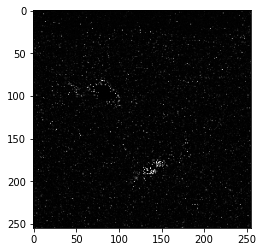

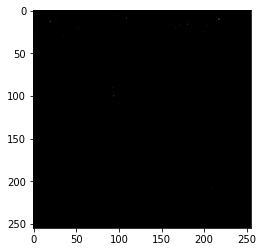

In [19]:
# print(predicted_image.shape)
plt.imshow(orginal_image*255, cmap='gray')
plt.show()

plt.imshow(predicted_image*255, cmap='gray')
plt.show()

In [ ]:
response = model.predict(x_test_noise)

Show some of the denoised examples.
Images from left to right are - Noisy image, original image, denoised image

In [ ]:
for index in range(3,6):
  plt.subplot(330 + 1)
  plt.imshow(x_test_noise[index])
  plt.subplot(330 + 2)
  plt.imshow(x_test[index])
  plt.subplot(330 + 3)
  plt.imshow(response[index])
  plt.show()

The distribution of noise on the test set.

In [ ]:
avg_mse   = []
avg_mean  = []
avg_sd    = []

for index in range(0,1000):
  avg_mean.append(np.mean(x_test[index] - response[index]))
  avg_mse.append(np.mean((x_test[index] - response[index])**2))
  avg_sd.append(np.std(x_test[index] - response[index]))

print("Mean:", np.sum(avg_mean)/1000)
print("MSE:", np.sum(avg_mse)/1000)
print("SD:", np.sum(avg_sd)/1000)

In [ ]:
from pandas import Series
import seaborn as sns

sns.distplot(avg_mean, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Model without skip connections

In [ ]:
def noSkipBlock(input_tensor, num_channels):
  conv1 = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
  relu  = Activation('relu')(conv1)
  conv2 = Conv2D(num_channels,(3,3),padding='same')(relu)

  output_tensor = Activation('relu')(conv2)
  return output_tensor

def build_noskip_model(height,width,num_channels,num_res_blocks):
    inp       = Input(shape=(height,width,3))
    conv      = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)

    for i in np.arange(0,num_res_blocks):
        block_out = noSkipBlock(block_out, num_channels)

    conv_m2   = Conv2D (3,(3,3),padding='same')(block_out)
    model     = Model(inputs =inp,outputs = conv_m2)

    return model

modelNoSkip = build_noskip_model(32,32,32,5)
modelNoSkip.name = 'NoSkipModel'
modelNoSkip.summary()

In [ ]:
modelNoSkip.compile(optimizer= Adam(beta_2 = 0.9),loss='mean_squared_error',metrics=['mse'])

historyNoSkip = modelNoSkip.fit(x_train_noisy, x_train, 128, 25, 1, validation_data=(x_test_noisy,x_test))

In [ ]:
response_noSkip = modelNoSkip.predict(x_test_noisy)

In [ ]:
for index in range(3,6):
  plt.subplot(440 + 1)
  plt.imshow(x_test_noisy[index])
  plt.subplot(440 + 2)
  plt.imshow(x_test[index])
  plt.subplot(440 + 3)
  plt.imshow(response[index])
  plt.subplot(440 + 4)
  plt.imshow(response_noSkip[index])
  plt.show()

In [ ]:
noskip_avg_mse   = []
noskip_avg_mean  = []
noskip_avg_sd    = []

for index in range(0,1000):
  noskip_avg_mean.append(np.mean(x_test[index] - response_noSkip[index]))
  noskip_avg_mse.append(np.mean((x_test[index] - response_noSkip[index])**2))
  noskip_avg_sd.append(np.std(x_test[index] - response_noSkip[index]))

print("Mean:", np.sum(noskip_avg_mean)/1000)
print("MSE:", np.sum(noskip_avg_mse)/1000)
print("SD:", np.sum(noskip_avg_sd)/1000)

In [ ]:
sns.distplot(noskip_avg_mean, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
             label='No Skip Net')

sns.distplot(avg_mean, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
             label = 'ResNet')

In [ ]:
#Resnet = [0.0027,0.0022,0.0020,0.0019,0.0018,0.0018,0.0017,0.0017,0.0017,0.0017,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0015,0.0015]

plt.plot(history.history['val_mse'])
plt.plot(historyNoSkip.history['val_mse'])
plt.title('Val MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['ResNet', 'No Skip Net'], loc='upper right')
plt.show()